# Part A

#  DOMAIN: Entertainment

# CONTEXT: 
    Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the

# DATA DESCRIPTION: 
The dataset comprises of images and its mask for corresponding human face.

# PROJECT OBJECTIVE: 
To build a face detection system.

# Steps and tasks: [ Total Score: 20 Marks]

# 1. Import and Understand the data 

### A. Import and read ‘images.npy’.

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow
import matplotlib.pyplot as plt
tensorflow.__version__

'2.9.1'

In [2]:
images = np.load('images.npy',allow_pickle=True)
images.shape

(409, 2)

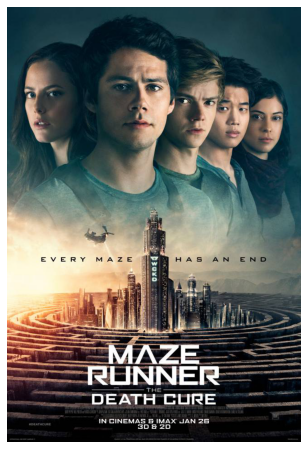

In [3]:
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(images[11][0])
plt.show()

In [4]:
print(images[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.
Imp Note: Replace all the pixels within masked area with 1.

Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1].

data= pd.DataFrame({'X':images[0],'Y':images[1]})

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224
ALPHA = 1

In [6]:
import cv2
from keras.applications.imagenet_utils import preprocess_input

In [7]:
Y = np.zeros((int(images.shape[0]),IMAGE_HEIGHT,IMAGE_WIDTH ))
X = np.zeros((int(images.shape[0]),IMAGE_HEIGHT,IMAGE_WIDTH,3))
for index in range(images.shape[0]):
    img = images[index][0]
    img = cv2.resize(img,dsize= (IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
        img = img[:,:,:3]
    except:
        continue
    X[index] = preprocess_input(np.array(img,dtype = np.float32))
    for i in images[index][1]:
        x1 = int (i['points'][0]['x']* IMAGE_WIDTH)
        x2 = int (i['points'][1]['x']* IMAGE_WIDTH)
        y1 = int (i['points'][0]['y']* IMAGE_HEIGHT)
        y2 = int (i['points'][1]['y']* IMAGE_HEIGHT)
        Y[index] [y1:y2, x1:x2] = 1

In [8]:
X.shape

(409, 224, 224, 3)

In [9]:
Y.shape

(409, 224, 224)

### C. Split the data into train and test[400:9].

In [10]:
X_train,X_test,y_train,y_test= train_test_split(X,Y,test_size= 9)

In [11]:
X_train.shape

(400, 224, 224, 3)

In [12]:
y_train.shape

(400, 224, 224)

In [13]:
X_test.shape

(9, 224, 224, 3)

In [14]:
y_test.shape

(9, 224, 224)

### D. Select random image from the train data and display original image and masked image.

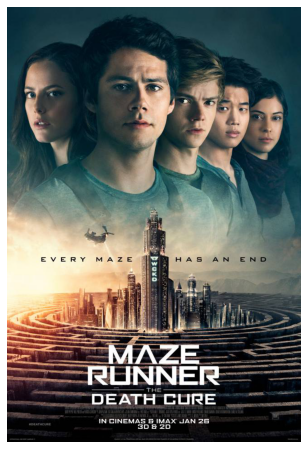

In [15]:
fig = plt.figure(figsize=(15,8))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(images[11][0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


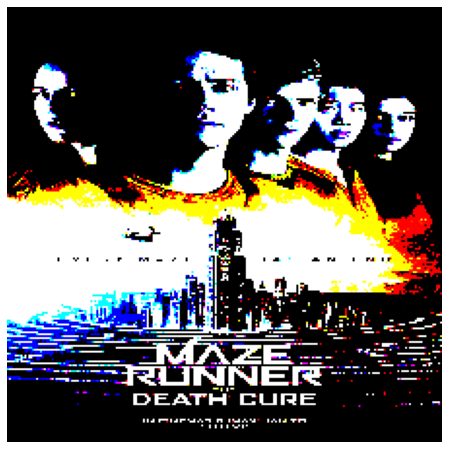

In [16]:
n=11
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.axis('off')
_ = plt.imshow(X[n])

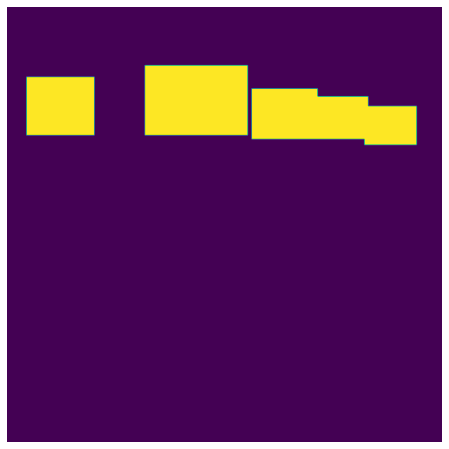

In [17]:
n=11 
fig = plt.figure(figsize = (15,8))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
_=plt.imshow(Y[n])

# 2. Model building

### A. Design a face mask detection model.

Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.

Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.

# 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.models
#from keras.layers import concatenate


def conv_block_simple(prevlayer,filters,prefix,strides=(1,1)):
    conv = Conv2D(filters, (3,3), padding = 'same', kernel_initializer='he_normal', strides= strides, name = prefix+'_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv= tf.keras.layers.Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    #block0 = model.layers[0].input    
    block1 = model.get_layer("conv_pw_13_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_1_relu").output
    
    up1 = Concatenate()([UpSampling2D()(block1),block2])
    conv6 = conv_block_simple(up1, 256, 'conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'conv_6_2')
    
    up2 = Concatenate()([UpSampling2D()(conv6),block3])
    conv7 = conv_block_simple(up2, 256, 'conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'conv_7_2')
    
    up3 = Concatenate()([UpSampling2D()(conv7),block4])
    conv8 = conv_block_simple(up3, 192, 'conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'conv_8_2')
    
    up4 = Concatenate()([UpSampling2D()(conv8),block5])
    conv9 = conv_block_simple(up4, 96, 'conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'conv_9_2')
    
    up5 = Concatenate()([UpSampling2D()(conv9),model.input])
    conv10 = conv_block_simple(up5, 48, 'conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'conv_10_2')
    conv10 = tf.keras.layers.SpatialDropout2D(0.2)(conv10)
    
    x= Conv2D(1, (1,1), activation = 'sigmoid')(conv10)
    x= Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model (inputs = model.input, outputs= x)
   

    

In [19]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

### B. Design your own Dice Coefficient and Loss function.

In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [21]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### C. Train and tune the model as required.

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

E:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [24]:
tr_history=model.fit(X_train,y_train,epochs = 30,verbose=1,batch_size=1,callbacks=[checkpoint,reduce_lr,stop],validation_data=(X_test,y_test))

Epoch 1/30

Epoch 1: loss improved from inf to 1.56562, saving model to model-1.57.h5
  1/400 [..............................] - ETA: 31:38 - loss: 1.5656 - dice_coefficient: 0.4385
Epoch 1: loss did not improve from 1.56562
  2/400 [..............................] - ETA: 3:46 - loss: 1.6764 - dice_coefficient: 0.4280 
Epoch 1: loss did not improve from 1.56562
  3/400 [..............................] - ETA: 3:49 - loss: 1.6856 - dice_coefficient: 0.4375
Epoch 1: loss did not improve from 1.56562
  4/400 [..............................] - ETA: 3:49 - loss: 2.4689 - dice_coefficient: 0.3352
Epoch 1: loss did not improve from 1.56562
  5/400 [..............................] - ETA: 3:49 - loss: 2.4530 - dice_coefficient: 0.3236
Epoch 1: loss did not improve from 1.56562
  6/400 [..............................] - ETA: 3:47 - loss: 2.5553 - dice_coefficient: 0.2911
Epoch 1: loss did not improve from 1.56562
  7/400 [..............................] - ETA: 3:48 - loss: 2.5245 - dice_coefficie

### D. Evaluate and share insights on performance of the model.

In [25]:
model.evaluate(X_test,y_test,verbose=1)
model.evaluate(X_train,y_train,verbose=1)

13/13 [==============================] - 39s 3s/step - loss: 0.5094 - dice_coefficient: 0.7653


[0.5093904733657837, 0.7652994990348816]

Text(0.5, 1.0, 'Training and validation loss')

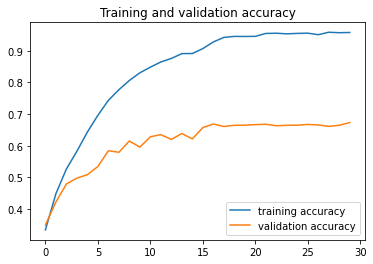

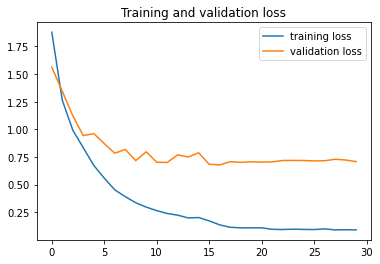

In [34]:
## Accuracy and Loss plots

dice_coefficient = tr_history.history['dice_coefficient']
val_dice_coefficient  = tr_history.history['val_dice_coefficient']
loss     = tr_history.history['loss']
val_loss = tr_history.history['val_loss']

epochs   = range(len(dice_coefficient)) # Get number of epochs

plt.plot  (epochs, dice_coefficient, label = 'training accuracy')
plt.plot  (epochs, val_dice_coefficient, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

1) Here Mobinet uses lower GPU and image quality. UNET is eliminating the drawback of mobilenet. 

2) Mobilenet initial layers at start followed by UNET because in real time photos, pictures will be of low,moderate and high quality. In the end images will be uploaded by api through cloud or hardwares. so both this model makes the system hybrid and gets the best out of it.

3) Found the best model after 30 epochs and saved the model weights "model-0.01.h5". 

4) Training - loss: 0.5094 - dice_coefficient: 0.7653

5) Validation/Testing: loss: 0.6212 - dice_coefficient: 0.7224

6) As seen in graph dice coefficient and loss are inversely proportional to eachother.

7) If Deviation is less that means the similarity is more. 

8) Further the training an validation is not overfitting

9) More Accuracy with respect to similarity can be gained  if we use mobilenetv3 and Unet++ in near future.

# 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [35]:
#load Seved model weight

WEIGHTS_FILE = "model-0.01.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred= learned_model.predict(X_test,verbose=1)

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


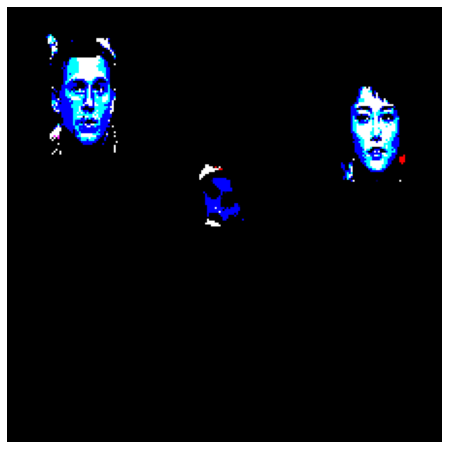

In [43]:
# Sample Image
#sample_image = X_test[3]
n=3
image = cv2.resize(X_test[n], dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
#feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
pred_mask = cv2.resize(1.0*(y_pred[n]> 0.1), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(out_image)

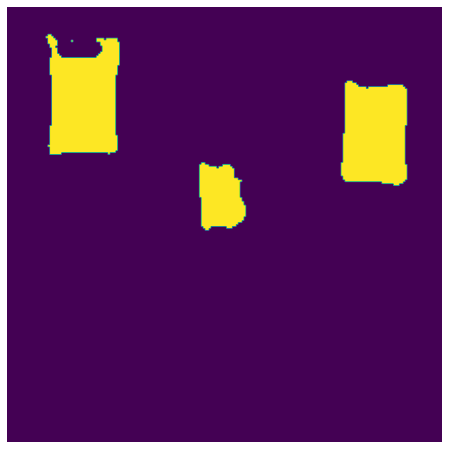

In [44]:
fig = plt.figure(figsize = (15,8))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(pred_mask,alpha=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


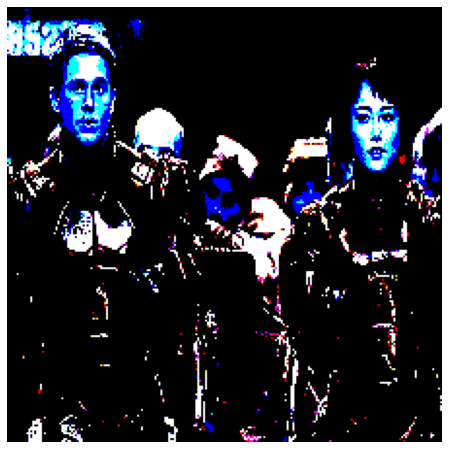

In [45]:
#from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg',1)
mask = cv2.imread('mask.jpg',1)
img= cv2.add(img,mask)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('Image.jpg',bbox_inches ='tight', pad_inches = 0)

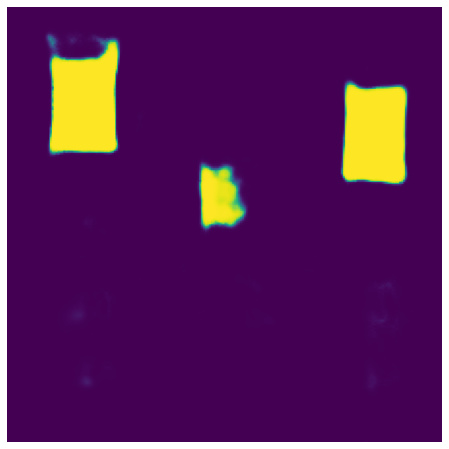

In [46]:
fig= plt.figure(figsize=(15,8))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(y_pred[n],alpha=1)
plt.savefig('mask.jpg',bbox_inches='tight',pad_inches=0)


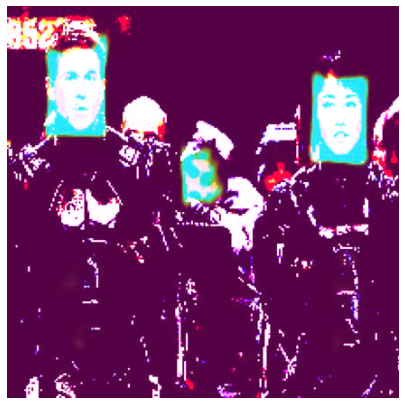

In [47]:
img= cv2.imread("image.jpg",1)
mask= cv2.imread("mask.jpg",1)
img= cv2.add(img,mask)

fig=plt.figure(figsize=(15,7.2))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(img)

# Part B

# DOMAIN: Entertainment

# CONTEXT: 
    Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the

# DATA DESCRIPTION: 
  The dataset comprises of face images.

# PROJECT OBJECTIVE: 

To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

# Steps and tasks:

## 1. Read/import images from folder ‘training_images’. [

In [1]:
Faceimages = "training_images-20211126T092819Z-001.zip"
from zipfile import ZipFile
with ZipFile(Faceimages,'r') as zip:
  zip.extractall("")

In [22]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

## 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. 

Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.

In [2]:
%pwd

'C:\\Users\\hp\\Computer vision'

In [3]:
import numpy as np
import os

class IdentityMetadata1():
    def __init__(self, base, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata1(path):
    metadata12 = []
    exts=[]
    for f in os.listdir(path):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata12.append(IdentityMetadata1(path,f))
                exts.append(ext)
    return np.array(metadata12),exts

# metadata = load_metadata('images')
metadata123,exts1 = load_metadata1('training_images')
labels1 =np.array([meta.file for meta in metadata123])

In [4]:
len(metadata123)

1091

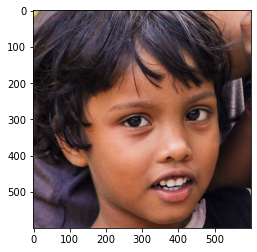

In [21]:
img_path = metadata123[0]
img = load_image(str(img_path))

fig = plt.figure(str(img_path))
ax=fig.add_subplot(1,1,1)
_=plt.imshow(img)

In [6]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [11]:
from tqdm.notebook import tqdm
import cv2

facedetected = []
images = []
facemeta= []

for i,meta in tqdm(enumerate(metadata123)):
    image =load_image(str(meta))
    images.append(image)
    
    image = cv2.resize(image,(224,224),interpolation = cv2.INTER_AREA)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+ 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.05,3)
    
    facemeta.append(faces)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y), (x+w,y+h),(225,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        
    facedetected.append(image)

0it [00:00, ?it/s]

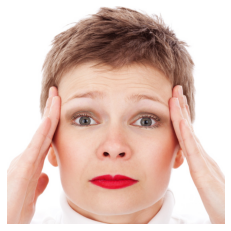

In [14]:

n=1
plt.axis('off')
_=plt.imshow(images[n])

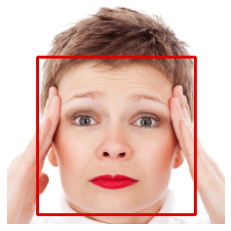

In [15]:
import matplotlib.pyplot as plt
n=1
plt.axis('off')
_=plt.imshow(facedetected[n])

## 3. From the same loop above, extract metadata of the faces and write into a DataFrame. 

In [24]:
x_cor= []
y_cor= []
wdth= []
height = []
nooffaces= []
image_name = []
for i, face in tqdm(enumerate(facemeta)):
    if(len(face)>0):
        for (x,y,w,h) in face:
            x_cor.append(x)
            y_cor.append(y)
            wdth.append(w)
            height.append(h)
            nooffaces.append(len(face))
            image_name.append(labels1[i])
    else:
        x_cor.append(0)
        y_cor.append(0)
        wdth.append(0)
        height.append(0)
        nooffaces.append(len(face))
        image_name.append(labels1[i])

0it [00:00, ?it/s]

In [25]:
import pandas as pd
Dataframe_images = pd.DataFrame({'x': x_cor,'y':y_cor,'w':wdth,'h':height,'Total_faces':nooffaces,'Image_name':image_name})

In [26]:
Dataframe_images.head()

x   y    w    h  Total_faces      Image_name
0  56  52  159  159            1  real_00001.jpg
1  31  52  162  162            1  real_00002.jpg
2  14  46  132  132            1  real_00003.jpg
3  50  63  136  136            2  real_00004.jpg
4   4   4   63   63            2  real_00004.jpg

## 4. Save the output Dataframe in .csv format.

In [27]:
Dataframe_images.to_csv('Facedetection.csv',index=False)

# Part C

## DOMAIN: Face Recognition

## CONTEXT:
Company X intends to build a face identification model to recognise human faces.

## DATA DESCRIPTION: 
The dataset comprises of images and its mask where there is a human face.

## PROJECT OBJECTIVE: 
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

## Steps and tasks:

## 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [32]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [19]:
import os
cwd=os.getcwd()

In [23]:
%pwd


'C:\\Users\\hp\\Computer vision'

In [20]:
import os; os.chdir(cwd)

In [29]:
images_path = "PINS.zip"
from zipfile import ZipFile
with ZipFile(images_path,'r') as zip:
  zip.extractall("")

## 2. Write function to create metadata of the image. 

Hint: Metadata means derived information from the available data which can be useful for particular problem statement.

In [31]:
import numpy as np
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    


## 3. Write a loop to iterate through each and every image and create metadata for all the images.

In [ ]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

## 4. Generate Embeddings vectors on the each face in the dataset.

Hint: Use ‘vgg_face_weights.h5’

In [33]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [34]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [36]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                      

In [37]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [38]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 929ms/step
(2622,)


In [40]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
    try:
        image = load_image(str(meta))
        image = (image/255.).astype(np.float32)
        image = cv2.resize(image, (224, 224))
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
    except:
        embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 235ms/step


## 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

Consider distance metric as "Squared L2 distance"
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [41]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [42]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

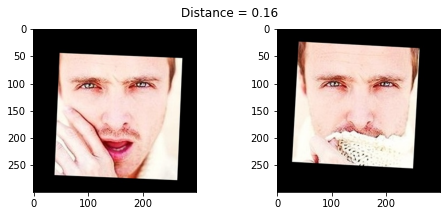

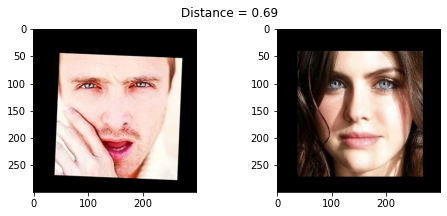

In [43]:
show_pair(2, 3)
show_pair(2, 180)

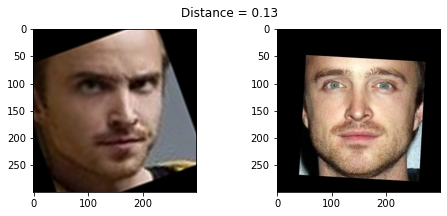

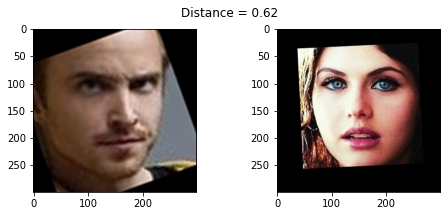

In [44]:
show_pair(30, 31)
show_pair(30, 100)

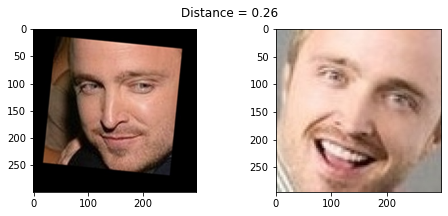

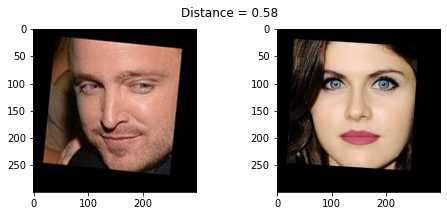

In [45]:
show_pair(70, 72)
show_pair(70, 115)

## 6. Use PCA for dimensionality reduction.

In [46]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9320, 2622)

(1166, 2622)

(9320,)

(1166,)

In [47]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [48]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [49]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.54529047  19.02462685  23.06968139 ...  99.99999983  99.99999999
 100.        ]


In [50]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


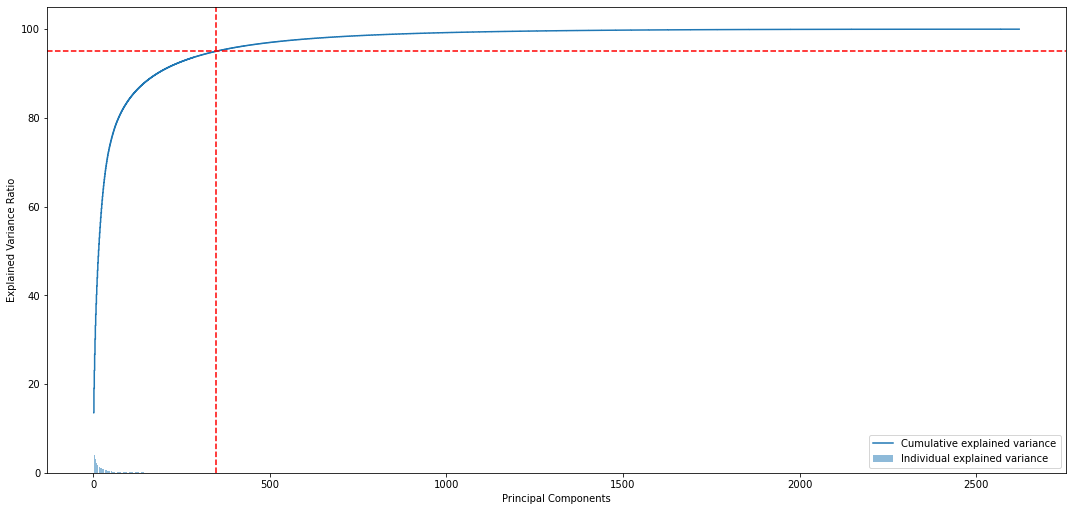

In [51]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [53]:
# Reducing the dimensions
random_state=47
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9320, 346)

(1166, 346)

## 7. Build an SVM classifier in order to map each image to its right person.

In [ ]:
#params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

#svc = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
#svc.fit(X_train_pca, y_train)
#
#print('Best estimator found by grid search:')
#print(svc.best_estimator_)
#

#Best estimator found by grid search:
#SVC(C = 10, gamma = 0.0001, kernel = 'rbf', class_weight = 'balanced')

In [55]:

#Best estimator found by grid search:
#SVC(C = 10, gamma = 0.0001, kernel = 'rbf', class_weight = 'balanced')

In [115]:
svc_pca = SVC(C = 10, gamma = 0.0001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [116]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.961


In [117]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      0.90      0.95        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       0.89      0.89      0.89         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

## 8. Import and display the the test images. 

Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

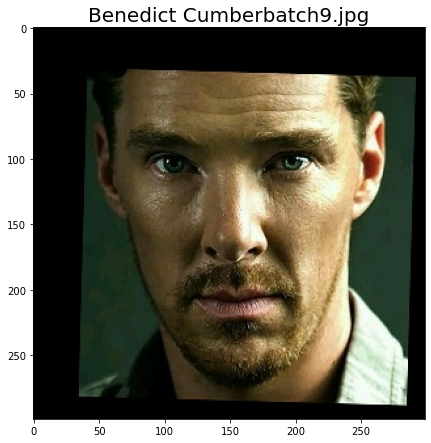

In [104]:
img_path1 = "Benedict Cumberbatch9.jpg"

Test1 = load_image(img_path1)

fig = plt.figure(figsize =(15,7.2))
ax=fig.add_subplot(1,1,1)
title = "Benedict Cumberbatch9.jpg"
ax.set_title(title,fontsize=20)
_=plt.imshow(Test1)

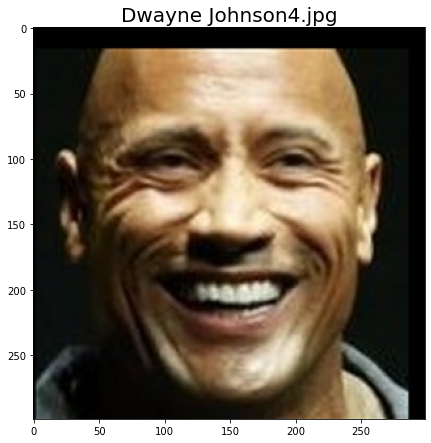

In [105]:
img_path2 = "Dwayne Johnson4.jpg"

Test2 = load_image(img_path2)

fig = plt.figure(figsize =(15,7.2))
ax=fig.add_subplot(1,1,1)
title = "Dwayne Johnson4.jpg"
ax.set_title(title,fontsize=20)
_=plt.imshow(Test2)

## 9. Use the trained SVM model to predict the face on both test images.

In [110]:
def sample_img_plot(testimage,actualname):
  # Load image for sample_idx from test data
  sample_img = load_image(testimage)
  # Get actual name
  actual_name = actualname
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 0s 272ms/step


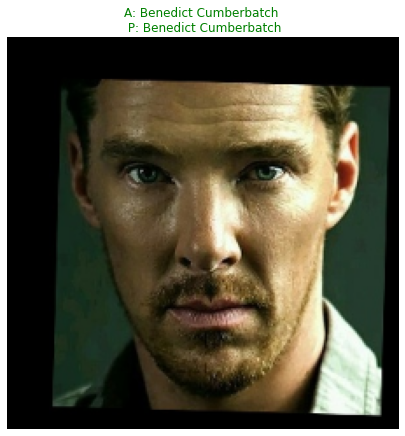

In [112]:
sample_img, actual_name, pred_name = sample_img_plot(img_path1,'Benedict Cumberbatch')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 [==============================] - 0s 344ms/step


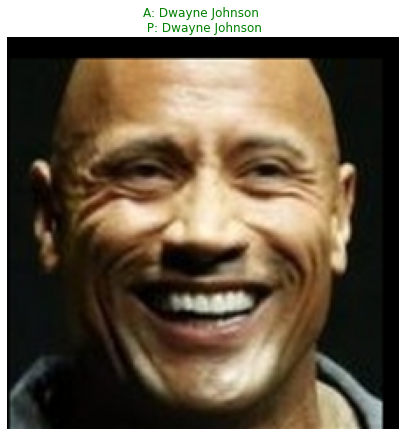

In [113]:
sample_img, actual_name, pred_name = sample_img_plot(img_path2,'Dwayne Johnson')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()